## Classification Search

In the cells below, the grayscale dataset is read from the directories. It is then trained and tested. Then it is normalized and cut with 99% PCA for better accuracy. Graphs are used to display the eigenvalues. Next there is a train test split for the 10 nearest neighbors which are calculated for the query image. Every process is timed in order to compare with the other image search methods in this project.

## Imports

In [1]:
# Imports
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageFile
from time import perf_counter
#from sklearn.decomposition.pca import PCA
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# seeding RNG
random_state = 12345
np.random.seed( random_state )

# Ensure datastream doesn't break on image data load
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Setup

## Timing Function and Globals

In [2]:
# ======================================================================
# FUNCTION: update_runtimes
# ======================================================================
# Input:
#   * runtimes: existing array of runtime dictionaries of the following form
#        [{'label':label_1, 'val':val_1, 'type':type_1}, 
#         ...,
#         {'label':label_n, 'val':val_n, 'type':type_n}]
#   * label: string representing the label key for the dictionary to be
#            added/updated
#   * val: numeric value representing the runtime (val key) of the dictionary
#          to be added/updated
#   * type: numeric (0,1) flag indicating whether the entry is a preprocessing
#           or a querying time (0=preprocessing, 1=querying)
# Output:
#   * an updated version of the runtimes array where if the label already
#     existed, its values are updated, otherwise a new entry is added with 
#     an appropriately formatted dictionary
# Task:
#   1. iterate over runtimes and test if that entry's "label" key matches
#      the given label value
#   2. If an entry exists, update its val and type keys to match the parameters
#   3. If none found during iteration, construct a dictionary of the appropriate
#      form using the given parameters, and append that dictionary to the
#      end of the list
#   4. Return the dictionary upon update or upon append
# ======================================================================
def update_runtimes( runtimes , label , val , type ):
    for i in range(len(runtimes)):
        if runtimes[i]['label'] == label:
            runtimes[i]['val']  = val
            runtimes[i]['type'] = type
            return runtimes
    runtimes.append( { 'label':label , 'val':val , 'type':type } )
    return runtimes


# === Globals Initialization === #
runtimes = list( )  # list to hold and record cell runtimes
data_dir = 'dataset/intel_images/full'

## setup: construct directory list

In [3]:
# ========================================================
# get_directory_list
# ========================================================
# Input: 
#   - data_dir: string containing absolute or relative path
#               to the root of the data files
# Output:
#   - list containing all subdirectories in the given data_dir
#     except for ".DS_Store" and "README"
# Task:
#   - Iterate over the directory list, and generate a new
#     list of the appropriate subdirectories
# ========================================================
def get_directory_list( data_dir ):
    return [ d for d in os.listdir( data_dir ) if d != '.DS_Store' and d != 'README' ]


# === Extract Directory List and Determine Time-Cost === #
t0       = perf_counter( )
dir_list = get_directory_list( data_dir )
t1       = perf_counter( )
runtimes = update_runtimes( runtimes , 'Directory List Construction' , ( t1 - t0 ) , 0 )


# === Print Results (Not Timed Since Not Necessary) === #
print( 'Directory List:\n' , dir_list )

Directory List:
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## setup: get train/test files

In [4]:
def get_file_list( data_dir , dir_list , n_per_class=50 ):
    all_files = list( )
    for d in dir_list:
        files      = [ data_dir + '/' + d + '/' + f for f in os.listdir( data_dir + '/' + d ) ]
        if n_per_class < len( files ):
            all_files += np.random.choice( files , n_per_class ).tolist( )
        else:
            all_files += files
    return all_files


t0 = perf_counter( )
file_list = get_file_list( data_dir , dir_list )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Training File List Construction' , ( t1 - t0 ) , 0 )

print(file_list[:10])

['dataset/intel_images/full/buildings/13822.jpg', 'dataset/intel_images/full/buildings/6290.jpg', 'dataset/intel_images/full/buildings/13079.jpg', 'dataset/intel_images/full/buildings/14318.jpg', 'dataset/intel_images/full/buildings/612.jpg', 'dataset/intel_images/full/buildings/21291.jpg', 'dataset/intel_images/full/buildings/16988.jpg', 'dataset/intel_images/full/buildings/15675.jpg', 'dataset/intel_images/full/buildings/12263.jpg', 'dataset/intel_images/full/buildings/23628.jpg']


## setup: get image shape

In [5]:
def get_data_dimensions( file_list ):
    return np.shape( Image.open( file_list[0] ).convert( "L" ) )


t0 = perf_counter( )
H , W = get_data_dimensions( file_list )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Data Dimension Extraction' , ( t1 - t0 ) , 0 )

print( 'Shape = %d x %d => %d Pixels' % ( H , W , H*W ) )

Shape = 150 x 150 => 22500 Pixels


## setup: displaying grid of images

In [6]:
def image_grid( D , H , W , cols=10 , scale=1 ):
    n    = np.shape( D )[0]
    rows = int( math.ceil( ( n + 0.0 ) / cols ) )
    fig  = plt.figure( 1 , figsize=[ scale * 20.0/H * W , scale * 20.0/cols * rows ] , dpi=300 )
    for i in range( n ):
        plt.subplot( rows , cols , i + 1 )
        fig = plt.imshow( np.reshape( D[i,:] , [H,W] ) , cmap=plt.get_cmap( "gray" ) )
        plt.axis( 'off' )
    plt.show( )

## setup: load data into memory

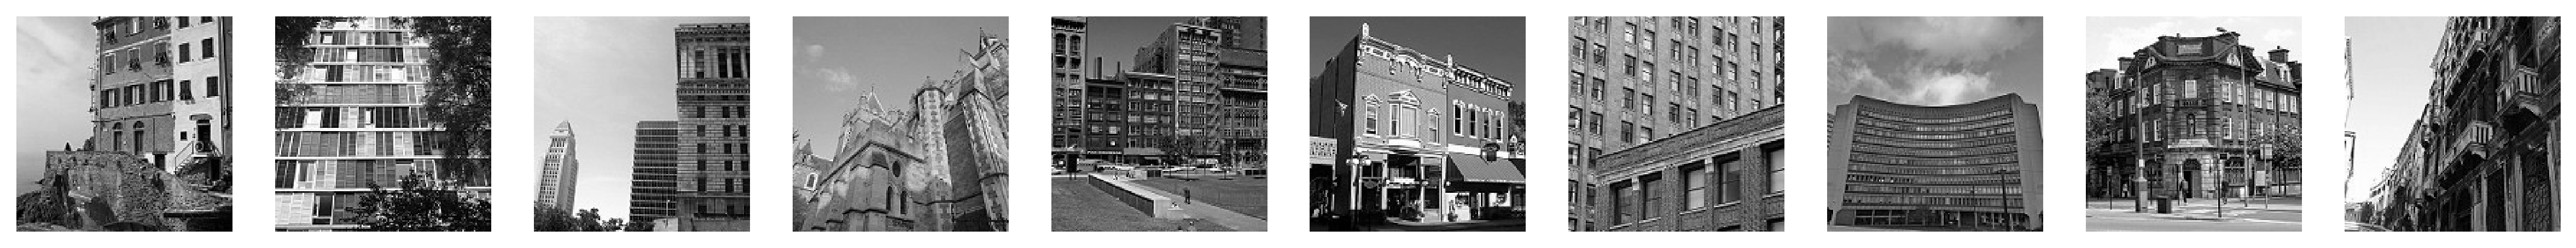

In [7]:
def create_images_array( file_list , H , W ):
    im_number = len( file_list )
    arr       = np.zeros( [ im_number , H * W ] )
    for i in range( im_number ):
        im = Image.open( file_list[i] ).convert( "L" )
        if np.shape( im ) != ( H , W ):
            im = im.resize( ( W , H ) )
        arr[i,:] = np.reshape( np.asarray( im ) , [ 1 , H * W ] )
    return arr


# === Call create_images_array On file_list === #
t0 = perf_counter( )
arr = create_images_array( file_list , H , W )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Train/Test Data Read' , ( t1 - t0 ) , 0 )


# === Show Successful Load by Displaying First 10 in Image Grid === #
image_grid( arr[:10] , H , W )

## Preprocessing: compute and display average image

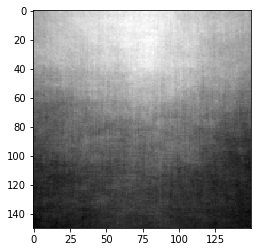

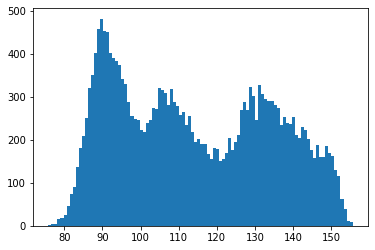

In [8]:
def get_mean_image( arr ):
    return np.mean( arr , axis=0 )

def plot_single_image( image , H , W ):
    plt.imshow( np.reshape( image , [ H , W ] ) , cmap=plt.get_cmap( "gray" ) )
    plt.figure( )
    plt.hist( image , bins=100 )
    plt.show( )
    return


# === Call create_images_array On file_list === #
t0 = perf_counter( )
mean_image = get_mean_image( arr )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Compute Date Mean' , ( t1 - t0 ) , 0 )


# === Show Successful Load by Displaying First 10 in Image Grid === #
plot_single_image( mean_image , H , W )

# looks like the mean photo has a light source about where the sun would be

## Preprocessing: Normalize Dataset

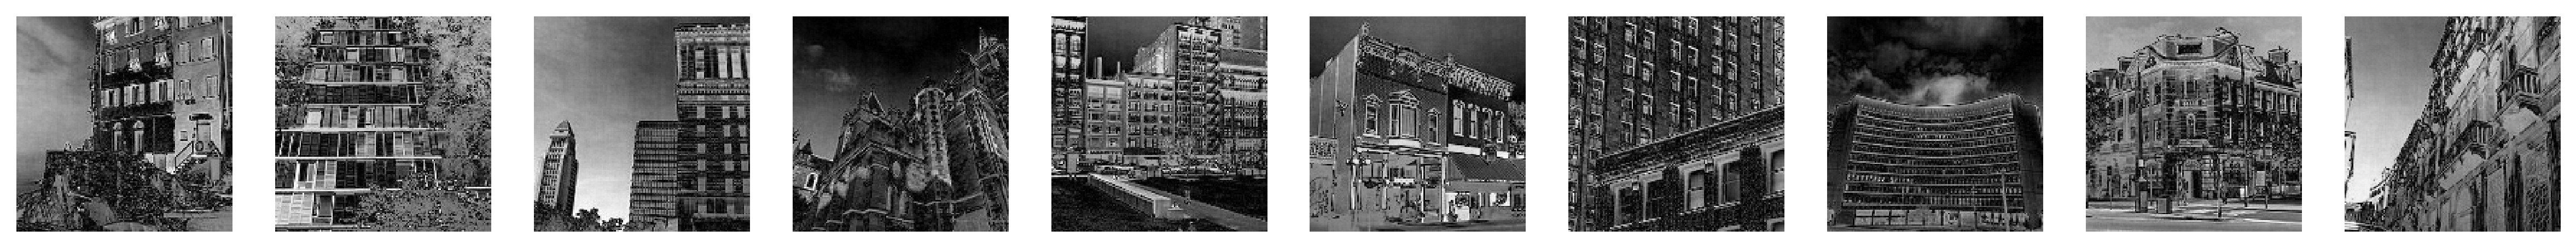

In [9]:
def normalize_image_data( image_array , mean_image ):
    return image_array - mean_image


# === Call create_images_array On file_list === #
t0 = perf_counter( )
arr_norm = normalize_image_data( arr , mean_image )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Normalize Data' , ( t1 - t0 ) , 0 )

# Display the First 10 Normalized Images
image_grid( np.abs(arr_norm[:10,:]) , H , W )

## Preprocessing: PCA

In [10]:
# === Perform Principle Component Analysis on the Dataset === #
t0 = perf_counter( )
pca = PCA( n_components=200 )
pca.fit( arr_norm )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'PCA' , ( t1 - t0 ) , 0 )

## (not timed): show eigenvalues of dataset

for analysis purposes. Not timed since it's not needed for search-by-image

Number of Eigenvalues:  (200,)


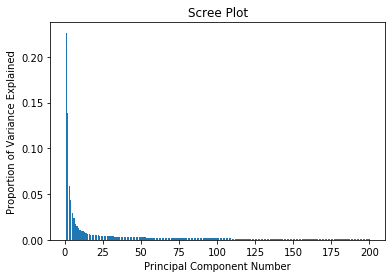

In [11]:
def plot_eigenvalues( fit_pca , pve=None ):
    if type( pve ) == type( None ):
        pve = fit_pca.explained_variance_ratio_
    
    print( 'Number of Eigenvalues: ' , pve.shape )
    plt.bar( x=range( 1 , len( pve ) + 1 ) , height=pve )
    plt.title( "Scree Plot" )
    plt.ylabel( "Proportion of Variance Explained" )
    plt.xlabel( "Principal Component Number" )
    plt.show( )


# === Plot the Eigenvalues to Satisfy Assignment Specs === #
plot_eigenvalues( pca )

## Cut Components to maintain 99% of explained variance

Components After Cut:  200
Number of Eigenvalues:  (200,)


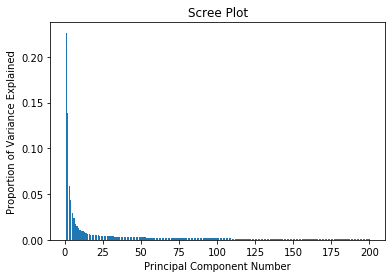

In [12]:
def cut_eigens( fit_pca , variance_thresh ):
    eigenfaces = fit_pca.components_
    pve        = fit_pca.explained_variance_ratio_
    variance   = 0
    for i in range( len( pve ) ):
        variance += pve[i]
        if variance >= variance_thresh:
            break
    return i , pve[:i+1] , eigenfaces[:i+1]


# === Cut the Eigens for the Fit Data, Satisfying Assignment Specs === #
t0 = perf_counter( )
cut_level , new_eigenvalues , new_eigenfaces = cut_eigens( pca , 0.99 )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Cutting Components' , ( t1 - t0 ) , 0 )

# === Show-Off the Cut by Displaying a New Scree Plot === #
print( 'Components After Cut: ' , len( new_eigenvalues ) )
plot_eigenvalues( pca , new_eigenvalues )

## Preprocessing: Construct X and y (data and labels)

In [13]:
def construct_X_y( data_norm , eigenfaces , data_dir , file_list ):
    X = np.dot( data_norm , eigenfaces.T )
    y = list( )
    for f in file_list:
        tmp = f.replace( data_dir , '' )[1:]
        y.append( tmp[:tmp.index( '/' )] )
    return X , np.array( y )


# === Construct X and y === #
t0 = perf_counter( )
X , y = construct_X_y( arr_norm , new_eigenfaces , data_dir , file_list )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Construct X and y' , ( t1 - t0 ) , 0 )

# === Show Success by Printing Shapes === #
print( 'Shape of X: ' , X.shape )
print( 'Shape of y: ' , y.shape )

Shape of X:  (300, 200)
Shape of y:  (300,)


## Preprocessing: train-test split

In [14]:
# === Partion X and y with an 80:20 Split === #
t0 = perf_counter( )
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify=y)
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Train-Test Split' , ( t1 - t0 ) , 0 )

# === Output the Shapes of the Train and Test Datasets === #
print( 'X Train Shape:' , X_train.shape )
print( 'y Train Shape:' , y_train.shape )
print( 'X Test Shape: ' , X_test.shape )
print( 'y Test Shape: ' , y_test.shape )

X Train Shape: (240, 200)
y Train Shape: (240,)
X Test Shape:  (60, 200)
y Test Shape:  (60,)


## Preprocessing: Fit a KNN (k=5) Classifier Model

In [15]:
# === Fit the KNN Classifier with k=5 === #
t0 = perf_counter( )
knn = KNeighborsClassifier( 5 )
knn.fit( X_train , y_train )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Fit the Model' , ( t1 - t0 ) , 0 )

## (not timed): Evaluate the Model's per-class accuracy

for analysis purposes. Not timed since not necessary for search-by-image, just for evaluation later

In [16]:
def get_accuracy_scores( X_train , X_test , y_train , y_test , scores=dict( ) , model=None ):
    # Fit model if none exists
    if type( model ) == type( None ):
        model = KNeighborsClassifier( 5 )
        model.fit( X_train , y_train )
        
    # Overall Accuracy 
    acc = model.score( X_test , y_test )
    
    # Compare Test Prediction to Truth to get Per-Class
    y_pred = model.predict( X_test )
    for i in range( len( y_test ) ):
        update = ( 0 , 1 )
        if y_test[i] == y_pred[i]:
            update = ( 1 , 1 )
        if y_test[i] in scores.keys( ):
            scores[y_test[i]] = ( scores[y_test[i]][0] + update[0] , scores[y_test[i]][1] + update[1] )
        else:
            scores[y_test[i]] = update
            
    return acc , scores


# print_scores_per_subject
def print_scores_per_subject( scores ):
    mean = lambda score: score[0] / score[1]
    for subject in sorted( scores.keys( ) ):
        print( '%-10s: %.8f' % ( subject , mean( scores[subject] ) ) )
    

# Extract the Accuracy Scores
acc_knn , scores_knn = get_accuracy_scores( X_train , X_test , y_train , y_test , model=knn )

# Print the Accuracy Score
print( 'KNN (k=1) Cumulative Test Accuracy Score: %0.8f\n' % acc_knn )
print( 'Per Class Accuracy Scores:' )
print_scores_per_subject( scores_knn )

KNN (k=1) Cumulative Test Accuracy Score: 0.41666667

Per Class Accuracy Scores:
buildings : 0.00000000
forest    : 0.80000000
glacier   : 0.50000000
mountain  : 0.70000000
sea       : 0.40000000
street    : 0.10000000


# Query

## Query: Extract Query Image Data and Class

Query Label: mountain
Query Image:


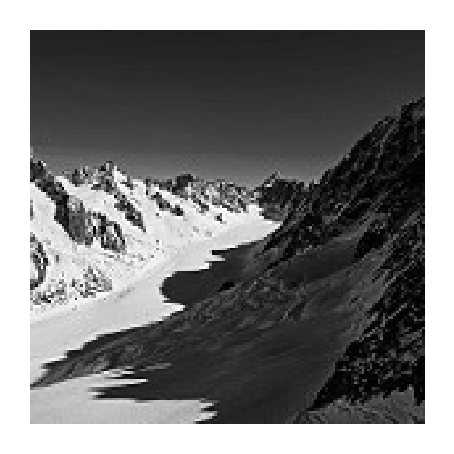

In [17]:
# === Read Into Array === #
t0               = perf_counter( )
query_image_file = 'query/demo.jpg'
query_label_file = 'query/demo.txt'
query_data       = create_images_array( [ query_image_file ] , H , W ) # get pixel data
with open( query_label_file ) as qlf: # read the Label data
    query_label = qlf.read( )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Extract Query Data' , ( t1 - t0 ) , 1 )


# === Display to Show Success === #
print( 'Query Label: {}'.format( query_label ) )
print( 'Query Image:' )
image_grid( query_data , H , W )

## Query: Classify the Query

In [18]:
# === Get Components, Cut, and Classify the Query Data === #
t0 = perf_counter( )
query_norm = normalize_image_data( query_data , mean_image )
query_components = pca.transform( query_norm )
query_cut = query_components[:,:len(X_train[0])]
query_pred = knn.predict(query_cut)[0]
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Extract Query Data' , ( t1 - t0 ) , 1 )

# === Display Predictions === #
print( 'Predicted Class of Query: ' , query_pred )

Predicted Class of Query:  forest


## Query: get candidate set by filtering dataset by query class

In [19]:
def get_candidates( data_dir , query_class , H , W ):
    candidate_files = get_file_list( data_dir , [query_class] , np.inf )
    candidates = create_images_array( candidate_files , H , W )
    return candidates , candidate_files

t0 = perf_counter( )
candidates , candidate_files = get_candidates( data_dir , query_pred , H , W )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Extract Query Data' , ( t1 - t0 ) , 1 )


print( 'Number of Candidates to Search: ' , candidates.shape[0] )

Number of Candidates to Search:  2745


## Query: n-neighbors search on candidate set

In [20]:
# ========================================================
# get_n_neighbors
# ========================================================
# Input: 
#   - query_data: array of the query's' pixel vector
#   - candidates: set of candidate pixel arrays to be searched
#   - candidate_files: list of filepaths coresponding to the candidates
#   - num_neighbors: positive int representing the number of desired 
#                    nearest neighbors
# Output:
#   - tuple of the form ( neibhors , neighbor_candidates , neighbor_files )
#        neighbors = (candiate_index,cosine_to_query) list of length num_neighbors
#                    sorted by descending cosine
#        neighbor_candidates = candidates filtered to the n-nearest neighbors in
#                              descending order
#        neighbor_files = the corresponding file paths to the neighbor images
# Task:
#   - compute cosine similarity from each candidate to the query
#   - sort by descending order of similarity
#   - filter to keep the num_neighbors most similar candidates
#   - filter candidate_files by the same indices
#   - return the tuple in the appropriate form
# ========================================================
def get_n_neighbors( query_data , candidates , num_neighbors ):
    # === Construct [(candidate_index,similarity)] list === #
    similarities      = np.zeros( ( len( candidates ) , 2 ) , dtype=object )
    similarities[:,0] = [ i for i in range( len( candidates ) ) ]
    similarities[:,1] = cosine_similarity( query_data , candidates )
    
    # === Sort, Slice, and Filter === #
    neighbors           = sorted( similarities , key=lambda x: x[1] , reverse=True )
    neighbors           = neighbors[ : min(num_neighbors , len( neighbors ) ) ]
    neighbor_candidates = candidates[ [ n[0] for n in neighbors ] ]
    
    # === Return Tuple === #
    return neighbors , neighbor_candidates


# === Perform Nearest Neighbor Search and Determine Time Cost === #
t0                = perf_counter( )
num_neighbors     = 10
neighbors_results = get_n_neighbors( query_data , candidates , num_neighbors)
neighbors , neighbor_candidates = neighbors_results
t1               = perf_counter( )
runtimes         = update_runtimes( runtimes , 'Query for N Neighbors' , ( t1 - t0 ) , 1 )


# === Display the Neighbor Set === #
print( '%d Nearest Neighbors:' % num_neighbors )
print( neighbors )

10 Nearest Neighbors:
[array([2456, 0.7985370731775722], dtype=object), array([530, 0.796441102174649], dtype=object), array([857, 0.7928994241688496], dtype=object), array([79, 0.7652733142369278], dtype=object), array([2218, 0.7648862700570964], dtype=object), array([1036, 0.7645258573131923], dtype=object), array([139, 0.7614882562530134], dtype=object), array([1130, 0.7613900309094832], dtype=object), array([2650, 0.7605562298688229], dtype=object), array([1986, 0.7597582289999228], dtype=object)]


## Results: Show the Query Results

Query:


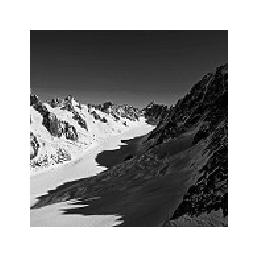

Ordered Neighbors:


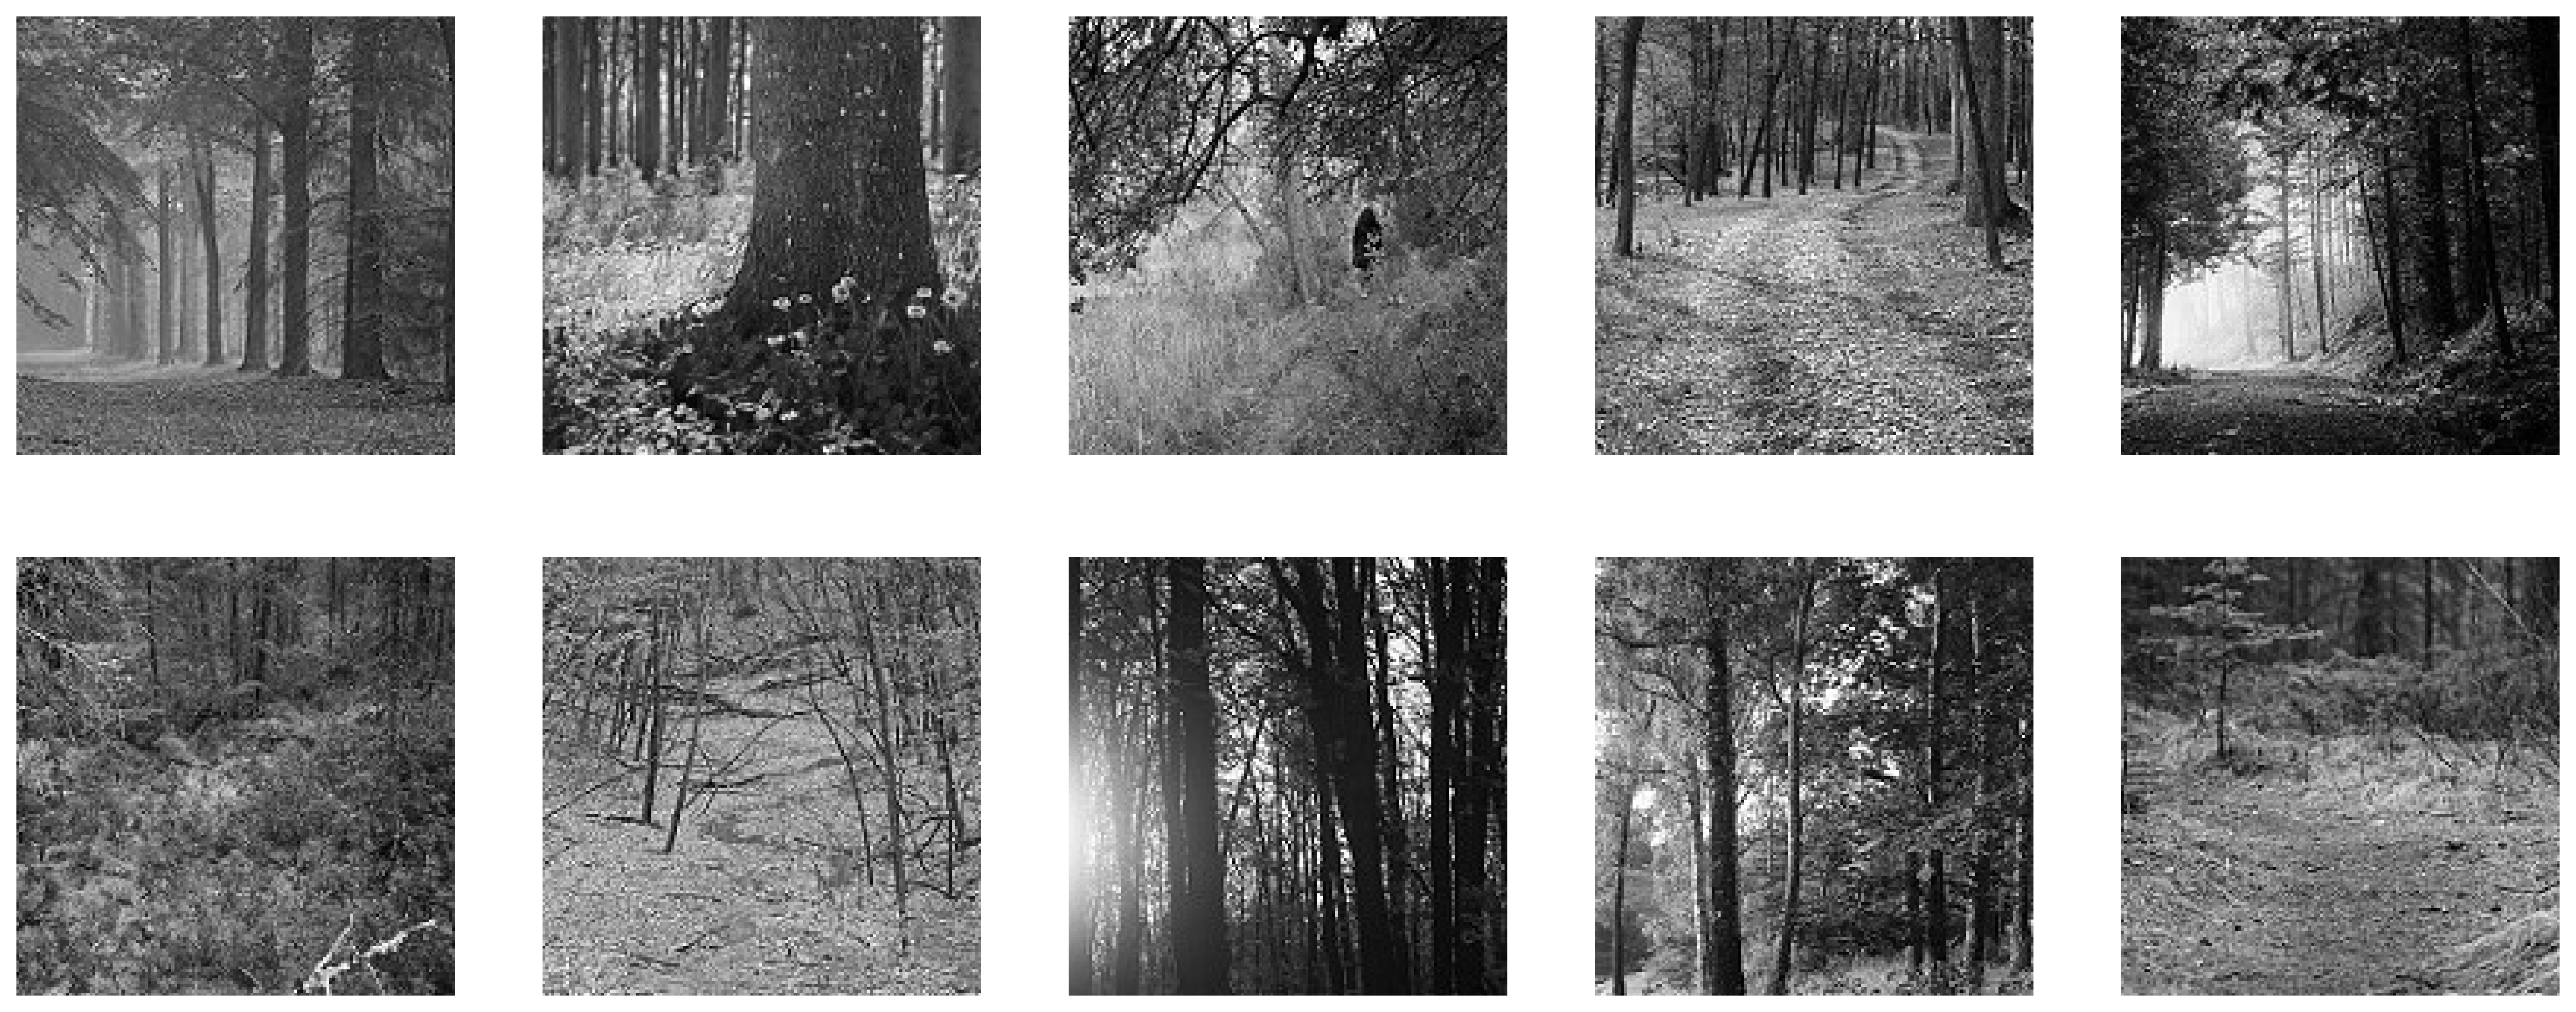

In [21]:
# ========================================================
# display_query_results_images
# ========================================================
# Input: 
#   - query_data: pixel vector of query
#   - neighbor_candidates: pixel vectors of nearest neighbors 
#                          in order
#   - H,W: dimensions of the images
# Output:
#   - formatted print of the data in the two lists
# Task:
#   - display the image grid of the query followed by 
#     the image grid of the candidates with appropriate
#     scaling and number of columns
# ========================================================
def display_query_results_images( query_data , neighbor_candidates , H , W ):
    print( 'Query:' )
    image_grid( query_data , H , W , scale=0.5 )
    print( 'Ordered Neighbors:' )
    image_grid( neighbor_candidates , H , W , cols=5 )
    return


# === Call the Above Function to Display === #
display_query_results_images( query_data , neighbor_candidates , H , W )

## Results: Display Demo Query Time-Costs

In [22]:
# ========================================================
# display_time_costs
# ========================================================
# Input: 
#   - runtimes: list of dictionaries with the keys {'label','val','type'}
# Output:
#   - no return, only a formatted print
# Task:
#   - iterate over the runtimes
#   - print each iterated value
#   - print the totals
# ========================================================
def display_time_costs( runtimes ):
    # === Counters === #
    total_time      = 0
    preprocess_time = 0
    query_time      = 0
    
    # === Iteratively Print === #
    print( 'TIME COST BREAKDOWN:' )
    for runtime in runtimes:
        print( '%-32s: %2.8fs' % ( runtime['label'] , runtime['val'] ) )
        total_time += runtime['val']
        if runtime['type'] == 0:
            preprocess_time += runtime['val']
        elif runtime['type'] == 1:
            query_time += runtime['val']
        continue

    # === Print Totals === #
    print( '' )
    print( 'TOTAL TIME COSTS:' )
    print( 'Preprocessing Time (Only Needed Once): %2.8fs' % preprocess_time )
    print( 'Query Time:                            %2.8fs' % query_time )
    print( 'Total Time:                            %2.8fs' % total_time )
    return


# === Call the Above Function === #
display_time_costs( runtimes )

TIME COST BREAKDOWN:
Directory List Construction     : 0.00046210s
Training File List Construction : 0.01441940s
Data Dimension Extraction       : 0.01913140s
Train/Test Data Read            : 0.34881400s
Compute Date Mean               : 0.00544740s
Normalize Data                  : 0.01655110s
PCA                             : 1.59737950s
Cutting Components              : 0.00012300s
Construct X and y               : 0.04216450s
Train-Test Split                : 0.00291980s
Fit the Model                   : 0.00243160s
Extract Query Data              : 2.96198380s
Query for N Neighbors           : 0.50197340s

TOTAL TIME COSTS:
Preprocessing Time (Only Needed Once): 2.04984380s
Query Time:                            3.46395720s
Total Time:                            5.51380100s


## Results: Evaluate Average Query Time Cost of 60 Queries

In [23]:
# === Setup: Get Query File Names and Prepare Variables for Use === #
query_dir        = 'query/batch'  # root of the query files
query_dir_list   = get_directory_list( query_dir )  # has a subdirectory for each class
query_file_list  = get_file_list( query_dir , query_dir_list )  # 10 files per subdirectory
query_metrics    = dict( )  # empty metrics dictionary
num_neighbors    = 10  # get 10 nearest neighbors
query_total_time = 0  # clear the timer


# === Query Each Query File One-at-a-Time === #
for query in query_file_list:
    
    # === Perform the Query === #
    query_start_time = perf_counter( )  # Start Timer
    
    # === Preprocessing: Get Class, Read Query Data, Hash Query === #
    query_label      = query.replace( query_dir , '' )[ 1: ]
    query_label      = query_label[:query_label.index('/')]
    query_array      = create_images_array( [query] , H , W )
    
    query_norm = normalize_image_data( query_array , mean_image )
    query_components = pca.transform( query_norm )
    query_cut = query_components[:,:len(X_train[0])]
    query_pred = knn.predict(query_cut)[0]
    
    # === Querying: candidate filtering, n-neighbor searching candidate set === #
    query_candidates , query_candidate_files  = get_candidates( data_dir , query_pred , H , W )
    neighbors_results = get_n_neighbors( query_array , query_candidates , num_neighbors)
    query_end_time    = perf_counter( )  # End Timer -- done querying
    
    # === Increment Total Time === #
    query_total_time += query_end_time - query_start_time
    
    # === Iterate === #
    continue  # for query
    
    
# === Extract Number of Queries Performed === #
num_queries = len( query_file_list )


# === Formatted Print Average Metrics === #
print( 'Average Query Time For %d Queries:  %2.8fs' % ( num_queries , query_total_time / num_queries ) )

Average Query Time For 60 Queries:  2.35913113s


## Evaluation:

The accuracy for this data set was lower than the dataset with face images. We speculate that this is because the classes of images overlap too much and look too similar to each other. We tested with both color images and greyscale images and the accuracy remained much lower than with the faces dataset. Images from different classes are overlapping for example: street images sometimes contain buildings and glacier images sometimes contain mountains which would even be difficult for a human to decide between. We learned that the dataset that is input is very important for the quality of results. When you feed a machine learning algorithm good data, it gives you good results. 

When we used .90 for the PCA to cut 90%, we got accuracy of around .30. The query image would return a whole seperate class of images and the nearest neighbors were all from another class of images. When we used .99 PCA to cut 99%, we got much better results with .45 accuracy. The query image returned the correct class as well as all the nearest neighbors were from the correct class. 

We tested both RGB and greyscale images and concluded that the images with color returned about 1-2% more accuracy than the greyscale images. This makes sense because glaciers and grass fields are different colors, but look very similar in greyscale.

We also tested the algorithm with the full dataset instead of the current scaled down version. It took magnitudes more time for the training even with 100% CPU usage and over 13GB of ram usage. This was not ideal because the results were similar in accuracy.

In the future, I would like to try datasets that are regional based. I would like to see if we can get reliable locations of land from different countries. For example I would want to try to use a dataset of pictures from the Himalayas and one from the Rocky Mountians. I would also want to incorporate cuda cores to see if they could speed up the processing.
